In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Embedding
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

In [2]:

# Function to load and preprocess data
def load_and_preprocess_data(sample_size=5000):
    # Load KDD dataset from URL
    url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
    col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
                "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
                "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
                "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
                "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

    df = pd.read_csv(url, names=col_names, compression='gzip')

    # Sample data
    df = df.sample(n=sample_size, random_state=42)

    # Encoding categorical variables into numeric form
    encoder = LabelEncoder()
    categorical_columns = ['protocol_type', 'service', 'flag']
    for col in categorical_columns:
        df[col] = encoder.fit_transform(df[col])

    # Convert labels into binary classification (attack or normal)
    df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal.' else 'attack')
    df['label'] = encoder.fit_transform(df['label'])

    # Feature Engineering: Creating new features
    df['byte_ratio'] = df['src_bytes'] / (df['dst_bytes'] + 1)
    df['total_count'] = df['count'] + df['srv_count']
    df['error_rate'] = (df['serror_rate'] + df['rerror_rate']) / 2

    # Split features and target
    X = df.drop('label', axis=1)
    y = df['label']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, X_train.shape[1]


In [3]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Precision: {precision:.4f}")
    print(f"{model_name} Recall: {recall:.4f}")
    print(f"{model_name} F1-Score: {f1:.4f}")
    print("-" * 50)
    print(classification_report(y_true, y_pred))

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

In [4]:
# Main function to train and evaluate all models
def main():
    # Load and preprocess data
    X_train, X_test, y_train, y_test, num_features = load_and_preprocess_data(sample_size=5000)

    results = []

    # 1. Original Models

    # Random Forest
    print("Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_rf, "Random Forest"))

    # Gradient Boosting
    print("Training Gradient Boosting...")
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_gb, "Gradient Boosting"))

    # SVM
    print("Training SVM...")
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_svm, "SVM"))

    # Basic Neural Network
    print("Training Basic Neural Network...")
    model = Sequential([
        Dense(64, activation='relu', input_shape=(num_features,)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
    results.append(evaluate_model(y_test, y_pred_nn, "Basic Neural Network"))

    # 2. Additional Machine Learning Models

    # Decision Tree
    print("Training Decision Tree...")
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_dt, "Decision Tree"))

    # K-Nearest Neighbors
    print("Training KNN...")
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_knn, "KNN"))

    # Logistic Regression
    print("Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_lr, "Logistic Regression"))

    # Naive Bayes
    print("Training Naive Bayes...")
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred_nb = nb.predict(X_test)
    results.append(evaluate_model(y_test, y_pred_nb, "Naive Bayes"))

    # 3. Additional Deep Learning Models

    # Reshape data for sequential models
    X_train_seq = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_seq = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # LSTM Model
    print("Training LSTM Model...")
    lstm_model = Sequential([
        LSTM(64, input_shape=(num_features, 1), return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lstm_history = lstm_model.fit(
        X_train_seq, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_test_seq, y_test),
        verbose=0
    )

    y_pred_lstm = (lstm_model.predict(X_test_seq) > 0.5).astype("int32")
    results.append(evaluate_model(y_test, y_pred_lstm, "LSTM"))

    # CNN Model
    print("Training CNN Model...")
    cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(num_features, 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    cnn_history = cnn_model.fit(
        X_train_seq, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_test_seq, y_test),
        verbose=0
    )

    y_pred_cnn = (cnn_model.predict(X_test_seq) > 0.5).astype("int32")
    results.append(evaluate_model(y_test, y_pred_cnn, "CNN"))

    # Create a pandas DataFrame from results
    results_df = pd.DataFrame(results)

    # Plot comparison bar graph
    plot_comparison(results_df)

    return results_df

In [5]:
def plot_comparison(results_df):
    """Create a bar graph comparing model metrics"""
    # Set up the figure and axes
    plt.figure(figsize=(15, 10))

    # Melt the dataframe to long format for easier plotting
    melted_df = pd.melt(results_df, id_vars=['Model'],
                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                        var_name='Metric', value_name='Value')

    # Create the grouped bar chart
    sns.barplot(x='Model', y='Value', hue='Metric', data=melted_df)

    plt.title('Performance Comparison of Different Network Attack Detection Models', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save the figure
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

Training Random Forest...
Random Forest Accuracy: 0.9970
Random Forest Precision: 0.9846
Random Forest Recall: 1.0000
Random Forest F1-Score: 0.9922
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      1.00      0.99       192

    accuracy                           1.00      1000
   macro avg       0.99      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.9970
Gradient Boosting Precision: 0.9846
Gradient Boosting Recall: 1.0000
Gradient Boosting F1-Score: 0.9922
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      1.00      0.99       192

    accuracy                           1.00      1000
   macro avg       0.99      1.00  

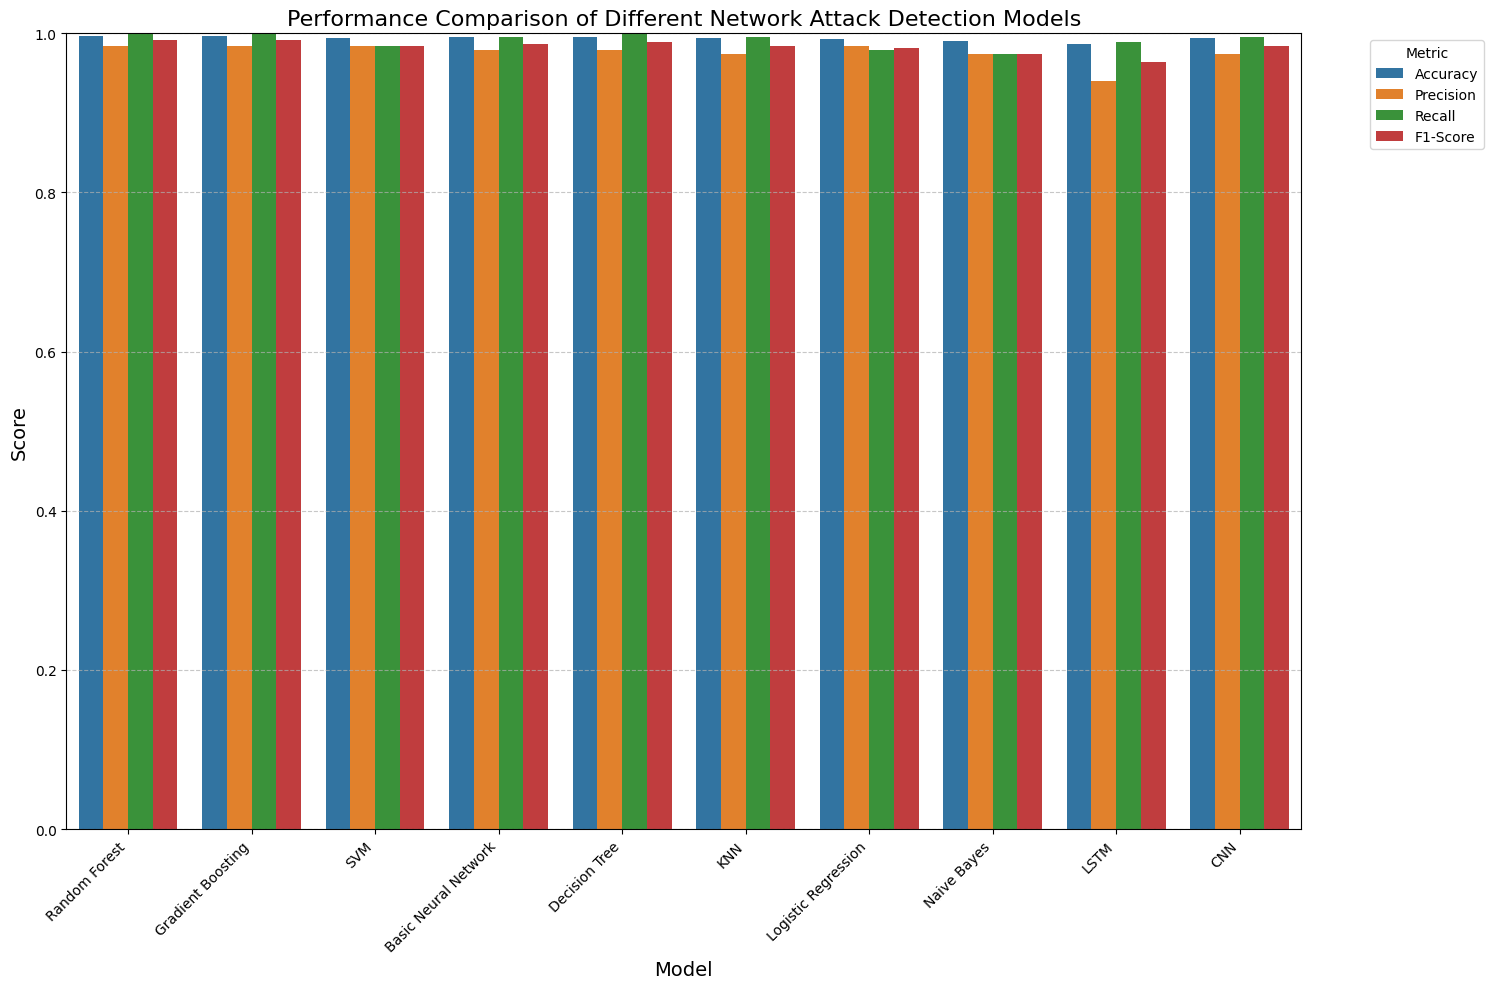


Results Summary:
                  Model  Accuracy  Precision    Recall  F1-Score
0         Random Forest     0.997   0.984615  1.000000  0.992248
1     Gradient Boosting     0.997   0.984615  1.000000  0.992248
4         Decision Tree     0.996   0.979592  1.000000  0.989691
3  Basic Neural Network     0.995   0.979487  0.994792  0.987080
5                   KNN     0.994   0.974490  0.994792  0.984536
9                   CNN     0.994   0.974490  0.994792  0.984536
2                   SVM     0.994   0.984375  0.984375  0.984375
6   Logistic Regression     0.993   0.984293  0.979167  0.981723
7           Naive Bayes     0.990   0.973958  0.973958  0.973958
8                  LSTM     0.986   0.940594  0.989583  0.964467


In [6]:
if __name__ == "__main__":
    results_df = main()
    print("\nResults Summary:")
    print(results_df.sort_values(by='F1-Score', ascending=False))